In [1]:
%cd "../.."

/home/ensai/projet-statistique-2022


In [2]:
from gensim import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import hdbscan as HD
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE

import seaborn as sns
import plotly.express as px


from word_embedding.distance_wmd import *
import doc_embedding.moyenne as moyenne
from reduction_dim.correlation_matrix import *
import clustering.fit_clustering as CL 

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
with open('data/docs.json', encoding = "utf8") as f:
    docs = json.load(f)

dict_moy_embedding = {}
for modele in ["glove","cbow","skipgram"]:
    ev = models.KeyedVectors.load_word2vec_format(f"data/tuning/{modele}.kv")
    #Read moy matrix
    dict_moy_embedding[modele] = {}
    dict_moy_embedding[modele]["TF"] = moyenne.word_emb_vers_doc_emb_moyenne(docs, ev, methode = 'TF')
    dict_moy_embedding[modele]["TFIDF"] = moyenne.word_emb_vers_doc_emb_moyenne(docs, ev, methode = 'TF-IDF')

In [4]:
dict_wmd_embedding = {}
for modele in ["glove","cbow","skipgram"]:
    #Read moy matrix
    dict_wmd_embedding[modele] = {}
    dict_wmd_embedding[modele]["Distance"] = np.array(lecture_fichier_distances_wmd(f"distances_{modele}.7z"))
    if modele != "glove":
        dict_wmd_embedding[modele]["MDS"] = np.array(pd.read_csv(f"data/tuning/MDS/{modele}_mds_embedding.csv",sep=";",header=0))

In [5]:
dict_embedding = {}
dict_embedding["WMD"] = dict_wmd_embedding
dict_embedding["Moyenne"] = dict_moy_embedding

In [6]:
df_hdbscan_clustering = pd.read_csv("data/tuning/clustering/hdbscan.csv",sep=";")
df_hdbscan_clustering["clustering"] = "hdbscan"
df_hdbscan_clustering["K"]  = df_hdbscan_clustering["K"] - 1
df_kmeans_clustering = pd.read_csv("data/tuning/clustering/kmeans.csv",sep=";")
df_gmm_clustering = pd.read_csv("data/tuning/clustering/gmm.csv",sep=";")
df_gmm_clustering["clustering"] = "gmm"
df_clustering = pd.concat([df_hdbscan_clustering,df_kmeans_clustering,df_gmm_clustering])
df_clustering = df_clustering[df_clustering["K"]>=5]
df_clustering = df_clustering[df_clustering["K"]<=20]
df_clustering["silhouette-DBCV"] = df_clustering[["silhouette","DBCV"]].apply(np.mean,axis=1)
df_clustering.head()

voisinage  min_cluster_size     distance  K  silhouette  Cal-Harabasz  \
41       20.0              11.0  precomputed  5    0.321917           NaN   
42       20.0              12.0  precomputed  5    0.321917           NaN   
51       19.0              10.0  precomputed  5    0.315283           NaN   
60       10.0              10.0  precomputed  5    0.340517           NaN   
81       42.0              10.0  precomputed  5    0.303762           NaN   

        DBCV  non_classes  perplexity wordEmbedding docEmbedding  \
41  0.119809        671.0         NaN          cbow          WMD   
42  0.119809        671.0         NaN          cbow          WMD   
51  0.114788        680.0         NaN          cbow          WMD   
60  0.108204        580.0         NaN          cbow          WMD   
81  0.089011        695.0         NaN          cbow          WMD   

   docEmbedding2 clustering initialisation  nb_iter  tolerance  val_obj  \
41      Distance    hdbscan            NaN      NaN        NaN      NaN   
42      Distance    hdbscan            NaN      NaN        NaN      NaN   
51      Distance    hdbscan            NaN      NaN        NaN      NaN   
60      Distance    hdbscan            NaN      NaN        NaN      NaN   
81      Distance    hdbscan            NaN      NaN        NaN      NaN   

   covariance  BIC  silhouette-DBCV  
41        NaN  NaN         0.220863  
42        NaN  NaN         0.220863  
51        NaN  NaN         0.215035  
60        NaN  NaN         0.224361  
81        NaN  NaN         0.196387

# Clustering Avant Tsne

In [7]:
df_clustering_before = df_clustering.loc[(df_clustering["perplexity"].isna())].reset_index()

In [8]:
df_clustering_before.loc[df_clustering_before.groupby(["wordEmbedding"])["Cal-Harabasz"].idxmax()]

index  voisinage  min_cluster_size distance  K  silhouette  Cal-Harabasz  \
252    186        NaN               NaN      NaN  5    0.405154  15339.302799   
312    578        NaN               NaN      NaN  5    0.035087    145.752720   
352    940        NaN               NaN      NaN  5    0.291723   5690.425304   

         DBCV  non_classes  perplexity  ... docEmbedding docEmbedding2  \
252 -0.753192          NaN         NaN  ...      Moyenne         TFIDF   
312 -0.697669          NaN         NaN  ...      Moyenne            TF   
352 -0.805468          NaN         NaN  ...      Moyenne         TFIDF   

    clustering initialisation nb_iter  tolerance     val_obj  covariance BIC  \
252     kmeans         random    10.0     0.0001  396.232829         NaN NaN   
312     kmeans      k-means++    10.0     0.0001    0.417098         NaN NaN   
352     kmeans         random    10.0     0.0001  604.194378         NaN NaN   

     silhouette-DBCV  
252        -0.174019  
312        -0.331291  
352        -0.256873  

[3 rows x 21 columns]

In [9]:
df_clustering_before.loc[df_clustering_before.groupby(["wordEmbedding"])["silhouette"].idxmax()]

index  voisinage  min_cluster_size   distance  K  silhouette  \
253    187        NaN               NaN        NaN  5    0.405681   
702   1810        NaN               NaN        NaN  5    0.160676   
99   22141        6.0              10.0  euclidean  5    0.481659   

     Cal-Harabasz      DBCV  non_classes  perplexity  ... docEmbedding  \
253  15337.873936 -0.749637          NaN         NaN  ...      Moyenne   
702     48.114086 -0.616269          NaN         NaN  ...      Moyenne   
99     489.760064 -0.248700        579.0         NaN  ...      Moyenne   

    docEmbedding2 clustering initialisation nb_iter  tolerance     val_obj  \
253         TFIDF     kmeans      k-means++    10.0     0.0001  396.268091   
702         TFIDF        gmm            NaN     NaN        NaN         NaN   
99          TFIDF    hdbscan            NaN     NaN        NaN         NaN   

     covariance           BIC  silhouette-DBCV  
253         NaN           NaN        -0.171978  
702        full -3.130738e+07        -0.227796  
99          NaN           NaN         0.116480  

[3 rows x 21 columns]

In [10]:
df_clustering_before.loc[df_clustering_before.groupby(["wordEmbedding"])["DBCV"].idxmax()]

index  voisinage  min_cluster_size     distance   K  silhouette  \
0       41       20.0              11.0  precomputed   5    0.321917   
67   10714        3.0              11.0    euclidean  11   -0.143543   
179  53569       38.0              10.0  precomputed   6    0.187349   

     Cal-Harabasz      DBCV  non_classes  perplexity  ... docEmbedding  \
0             NaN  0.119809        671.0         NaN  ...          WMD   
67      12.868416  0.003273       9215.0         NaN  ...      Moyenne   
179           NaN  0.278496        481.0         NaN  ...          WMD   

    docEmbedding2 clustering initialisation nb_iter  tolerance  val_obj  \
0        Distance    hdbscan            NaN     NaN        NaN      NaN   
67             TF    hdbscan            NaN     NaN        NaN      NaN   
179      Distance    hdbscan            NaN     NaN        NaN      NaN   

     covariance BIC  silhouette-DBCV  
0           NaN NaN         0.220863  
67          NaN NaN        -0.070135  
179         NaN NaN         0.232923  

[3 rows x 21 columns]

In [11]:
df_clustering_before.loc[df_clustering_before.groupby(["wordEmbedding"])["silhouette-DBCV"].idxmax()]

index  voisinage  min_cluster_size     distance   K  silhouette  \
3       60       10.0              10.0  precomputed   5    0.340517   
687   1789        NaN               NaN          NaN  10    0.121942   
179  53569       38.0              10.0  precomputed   6    0.187349   

     Cal-Harabasz      DBCV  non_classes  perplexity  ... docEmbedding  \
3             NaN  0.108204        580.0         NaN  ...          WMD   
687     40.366338       NaN          NaN         NaN  ...      Moyenne   
179           NaN  0.278496        481.0         NaN  ...          WMD   

    docEmbedding2 clustering initialisation nb_iter  tolerance  val_obj  \
3        Distance    hdbscan            NaN     NaN        NaN      NaN   
687         TFIDF        gmm            NaN     NaN        NaN      NaN   
179      Distance    hdbscan            NaN     NaN        NaN      NaN   

     covariance           BIC  silhouette-DBCV  
3           NaN           NaN         0.224361  
687        diag -3.327373e+07         0.121942  
179         NaN           NaN         0.232923  

[3 rows x 21 columns]

# Clustering Apres Tsne

In [12]:
df_clustering_after = df_clustering.loc[(df_clustering["perplexity"].notna())].reset_index()

In [13]:
df_clustering_after.loc[df_clustering_after.groupby(["wordEmbedding"])["Cal-Harabasz"].idxmax()]

index  voisinage  min_cluster_size distance   K  silhouette  \
11158    338        NaN               NaN      NaN  14    0.404300   
12138   1924        NaN               NaN      NaN  10    0.373191   
11638   1092        NaN               NaN      NaN  14    0.383962   

       Cal-Harabasz      DBCV  non_classes  perplexity  ... docEmbedding  \
11158  24527.133503 -0.618270          NaN       200.0  ...      Moyenne   
12138   8995.073630 -0.757997          NaN        50.0  ...          WMD   
11638  14189.799335 -0.630786          NaN       200.0  ...      Moyenne   

      docEmbedding2 clustering initialisation nb_iter  tolerance  \
11158         TFIDF     kmeans      k-means++    10.0     0.0001   
12138      Distance     kmeans         random    10.0     0.0001   
11638         TFIDF     kmeans         random    10.0     0.0001   

            val_obj  covariance BIC  silhouette-DBCV  
11158  2.545374e+05         NaN NaN        -0.106985  
12138  3.064856e+06         NaN NaN        -0.192403  
11638  3.457451e+05         NaN NaN        -0.123412  

[3 rows x 21 columns]

In [14]:
df_clustering_after.loc[df_clustering_after.groupby(["wordEmbedding"])["DBCV"].idxmax()]

index  voisinage  min_cluster_size   distance   K  silhouette  \
431    2295      200.0             100.0  euclidean   5   -0.269958   
2531  14536      150.0              10.0  euclidean  11   -0.298547   
8982  49886       48.0             100.0  euclidean  19   -0.162440   

      Cal-Harabasz      DBCV  non_classes  perplexity  ... docEmbedding  \
431     753.185680  0.147703       5828.0       100.0  ...          WMD   
2531    276.077154  0.116965       5841.0       150.0  ...      Moyenne   
8982    632.930565  0.115563       4671.0        75.0  ...      Moyenne   

     docEmbedding2 clustering initialisation nb_iter  tolerance  val_obj  \
431       Distance    hdbscan            NaN     NaN        NaN      NaN   
2531            TF    hdbscan            NaN     NaN        NaN      NaN   
8982            TF    hdbscan            NaN     NaN        NaN      NaN   

      covariance BIC  silhouette-DBCV  
431          NaN NaN        -0.061128  
2531         NaN NaN        -0.090791  
8982         NaN NaN        -0.023439  

[3 rows x 21 columns]

In [15]:
df_clustering_after.loc[df_clustering_after.groupby(["wordEmbedding"])["silhouette"].idxmax()]

index  voisinage  min_cluster_size distance  K  silhouette  \
11176    356        NaN               NaN      NaN  5    0.493015   
12214   2018        NaN               NaN      NaN  6    0.383739   
11451    819        NaN               NaN      NaN  8    0.412623   

       Cal-Harabasz      DBCV  non_classes  perplexity  ... docEmbedding  \
11176  20271.669489 -0.659591          NaN       200.0  ...      Moyenne   
12214   8468.996606 -0.825968          NaN       125.0  ...          WMD   
11451  11656.610215 -0.708491          NaN        75.0  ...          WMD   

      docEmbedding2 clustering initialisation nb_iter  tolerance  \
11176         TFIDF     kmeans         random    10.0     0.0001   
12214      Distance     kmeans      k-means++    10.0     0.0001   
11451           MDS     kmeans         random    10.0     0.0001   

            val_obj  covariance BIC  silhouette-DBCV  
11176  9.235383e+05         NaN NaN        -0.083288  
12214  2.185364e+06         NaN NaN        -0.221115  
11451  8.768532e+05         NaN NaN        -0.147934  

[3 rows x 21 columns]

In [16]:
df_clustering_before.loc[df_clustering_before.groupby(["wordEmbedding"])["silhouette-DBCV"].idxmax()]

index  voisinage  min_cluster_size     distance   K  silhouette  \
3       60       10.0              10.0  precomputed   5    0.340517   
687   1789        NaN               NaN          NaN  10    0.121942   
179  53569       38.0              10.0  precomputed   6    0.187349   

     Cal-Harabasz      DBCV  non_classes  perplexity  ... docEmbedding  \
3             NaN  0.108204        580.0         NaN  ...          WMD   
687     40.366338       NaN          NaN         NaN  ...      Moyenne   
179           NaN  0.278496        481.0         NaN  ...          WMD   

    docEmbedding2 clustering initialisation nb_iter  tolerance  val_obj  \
3        Distance    hdbscan            NaN     NaN        NaN      NaN   
687         TFIDF        gmm            NaN     NaN        NaN      NaN   
179      Distance    hdbscan            NaN     NaN        NaN      NaN   

     covariance           BIC  silhouette-DBCV  
3           NaN           NaN         0.224361  
687        diag -3.327373e+07         0.121942  
179         NaN           NaN         0.232923  

[3 rows x 21 columns]

# Plot ScatterPlot

In [22]:
def plot_best(df_clustering,dict_embedding,clustering_metric="silhouette",modele="cbow"):
    best_model = df_clustering.loc[df_clustering.groupby(["wordEmbedding"])[clustering_metric].idxmin()] if clustering_metric == "BIC" else df_clustering.loc[df_clustering.groupby(["wordEmbedding"])[clustering_metric].idxmax()]
    best_model = best_model[best_model["wordEmbedding"]==modele]

    if len(best_model) > 0:
        tsne_metric = "precomputed" if best_model["docEmbedding2"].values[0] == "Distance" else "euclidean"
        first_reduce = best_model["perplexity"].notna().values[0]

        doc_embedding = dict_embedding[best_model["docEmbedding"].values[0]][modele]

        tsne = TSNE(n_components = 2, perplexity=200, n_iter=2000, random_state=0,metric=tsne_metric)
        tsne_embedding = tsne.fit_transform(doc_embedding[best_model["docEmbedding2"].values[0]])
        clustering_data = tsne_embedding if first_reduce else doc_embedding[best_model["docEmbedding2"].values[0]]

        type_clustering = best_model["clustering"].values[0].upper()

        if type_clustering == "HDBSCAN":
            clust_model = HD.HDBSCAN(min_cluster_size=int(best_model["min_cluster_size"].values[0]), metric = best_model["distance"].values[0],min_samples=int(best_model["voisinage"].values[0]))
        elif type_clustering == "GMM":
            clust_model = GMM(n_components=best_model["K"].values[0],covariance_type=best_model["covariance"].values[0])
        elif type_clustering == "KMEANS":
            clust_model = KMeans(n_clusters = best_model["K"].values[0], init = best_model["initialisation"].values[0])
        elif type_clustering == "KMEDOIDES":
            clust_model = KMedoids(n_clusters = best_model["K"].values[0], init = best_model["initialisation"].values[0], metric = 'precomputed')

        labels = clust_model.fit_predict(np.array(clustering_data).astype(np.float64))

        color_palette = sns.color_palette('Paired', len(np.unique(labels)))
        
        cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in labels]

        title = f"Best DocEmbedding Clustering based on {clustering_metric} metric from {type_clustering} algorithm"
        subtitle1 = f"WordEmbedding: {modele} - DocEmbedding: {best_model['docEmbedding'].values[0]} {best_model['docEmbedding2'].values[0]} - Reducing Before Clustering: {first_reduce}" 
        subtitle2 = f"Number of cluster: {len(np.unique(labels))} - Silhouette: {round(best_model['silhouette'].values[0],2)} - DBCV: {round(best_model['DBCV'].values[0],2)} - Calinski-Harabasz: {round(best_model['Cal-Harabasz'].values[0],2)}"
        title=f"{title}\n{subtitle1}\n{subtitle2}"


        return labels,tsne_embedding, cluster_colors, title
    else: 
        return [None, None,None,None]

In [35]:
dict_label = {"ReductionFirst":{},"ReductionAfter":{}}

############################################################################################################################
                                                  SKIPGRAM                                                                         
############################################################################################################################


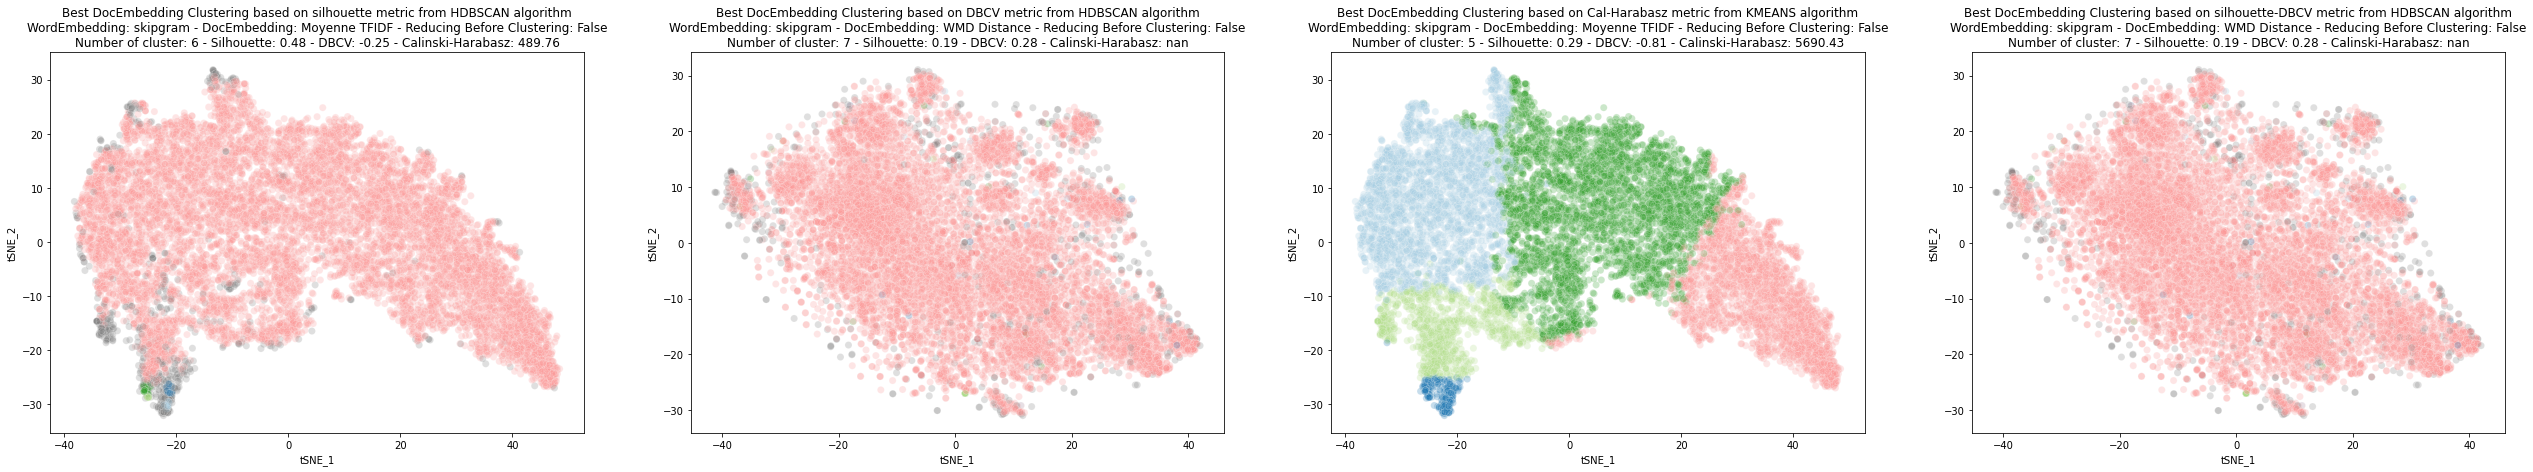

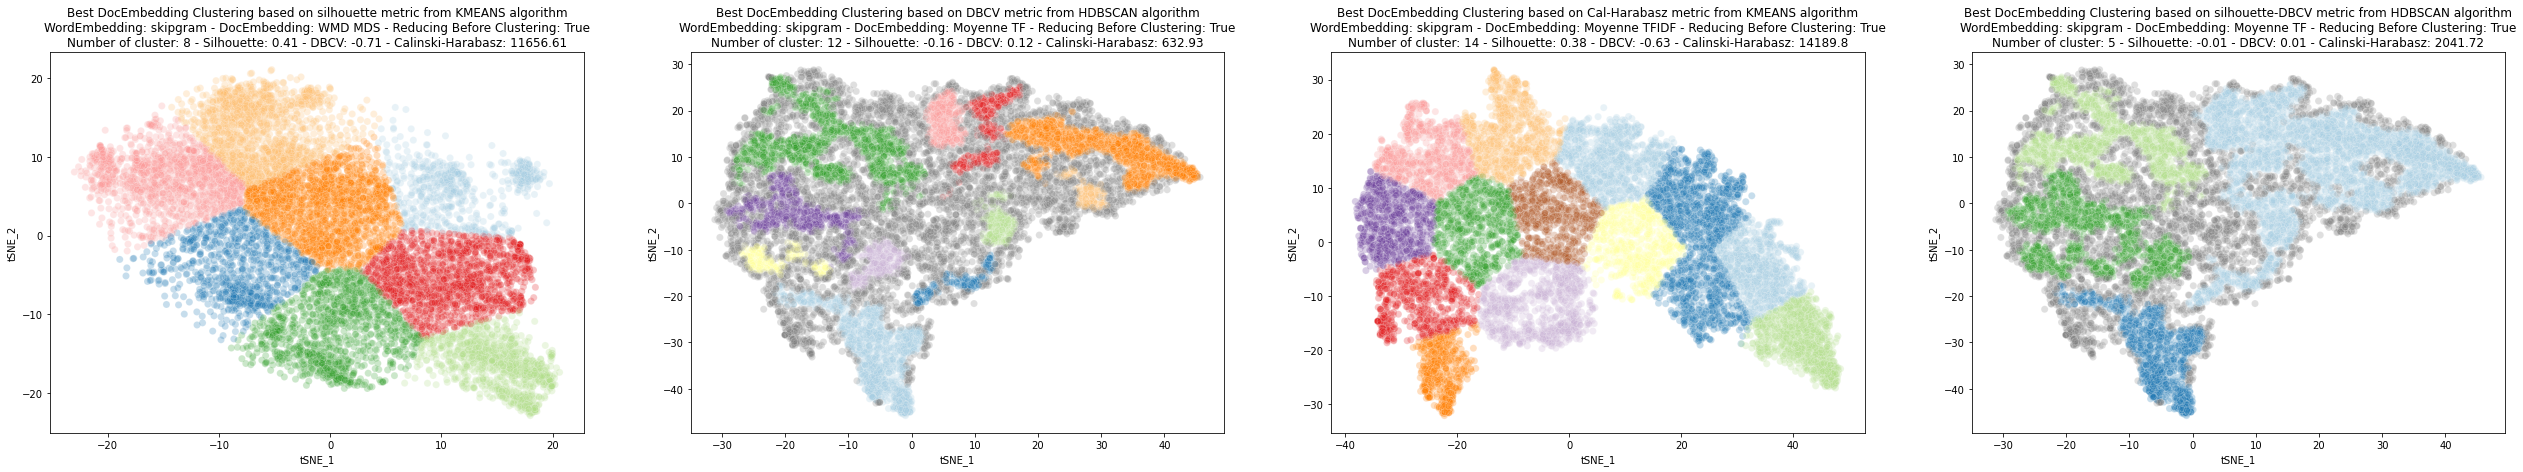

In [36]:
modele = "skipgram"
print("############################################################################################################################")
print(f"                                                  {modele.upper()}                                                                         ")
print("############################################################################################################################")
dict_label["ReductionFirst"][modele] = {}
dict_label["ReductionAfter"][modele] = {}
for type_reduction in ["ReductionAfter","ReductionFirst"]:
    all_metric = ["silhouette","DBCV", "Cal-Harabasz","silhouette-DBCV"]

    plt.figure(figsize = (44,7))
    for i in range(len(all_metric)):
        dict_label[type_reduction][modele][all_metric[i]] = {}
        #Silhouette
        if type_reduction == "ReductionAfter":
            Labels, Tsne, Colors, Title = plot_best(df_clustering_before,dict_embedding,clustering_metric=all_metric[i],modele=modele)
        else:
            Labels, Tsne, Colors, Title = plot_best(df_clustering_after,dict_embedding,clustering_metric=all_metric[i],modele=modele)
        
        filename = f"{modele}_{type_reduction.lower()}_{all_metric[i]}.csv"
        dict_label[type_reduction][modele][all_metric[i]]["labels"] = Labels
        dict_label[type_reduction][modele][all_metric[i]]["datafilename"] = filename
        pd.DataFrame(Tsne).to_csv(f"data/tuning/clustering/bestmodel/{filename}",sep=";",index=False)
        #plot
        sns.scatterplot(Tsne[:,0],Tsne[:,1], s=50, c=Colors, alpha=0.25,ax=plt.subplot(1,len(all_metric),i+1,title=Title,xlabel="tSNE_1",ylabel="tSNE_2"))
    plt.show()

############################################################################################################################
                                                  GLOVE                                                                         
############################################################################################################################


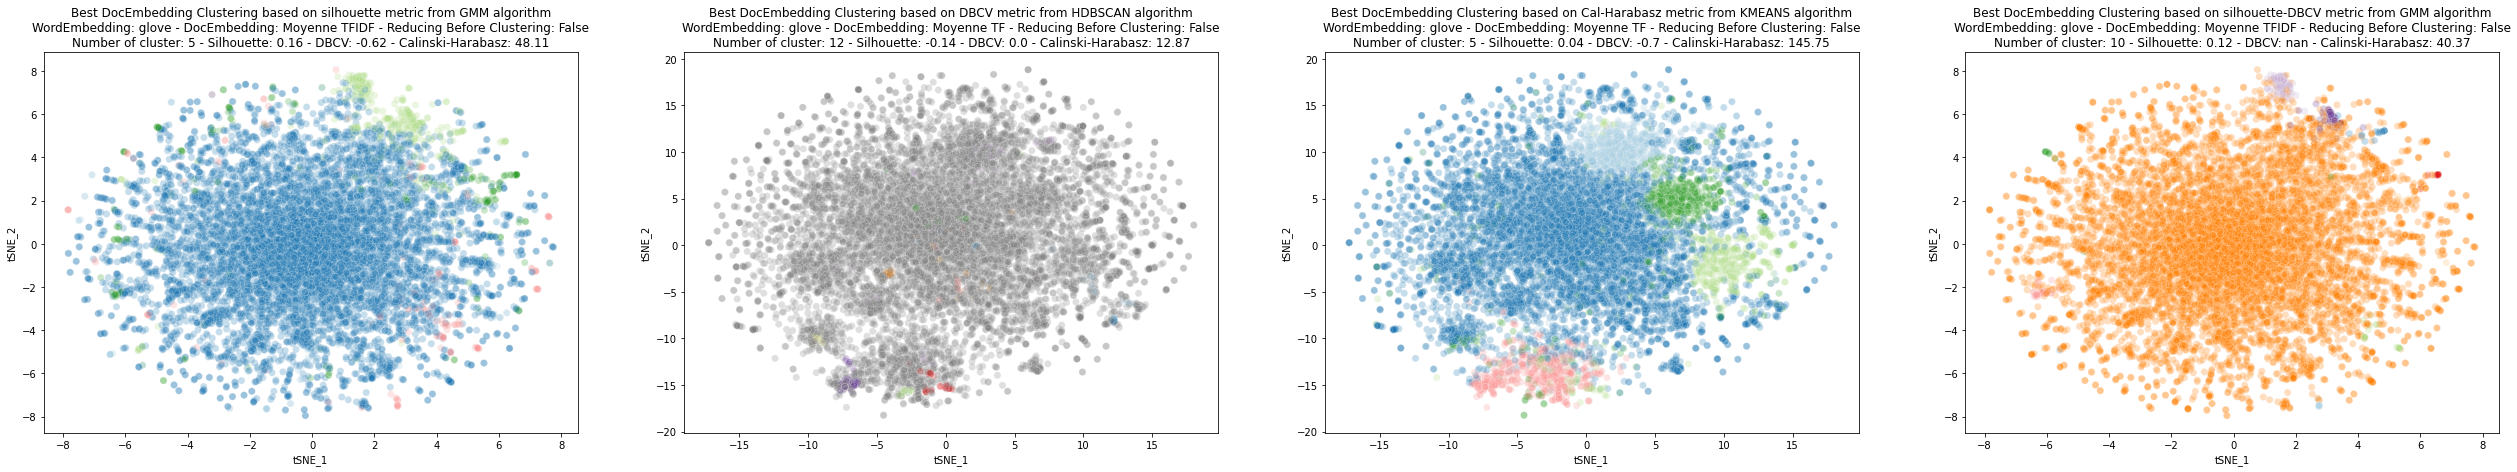

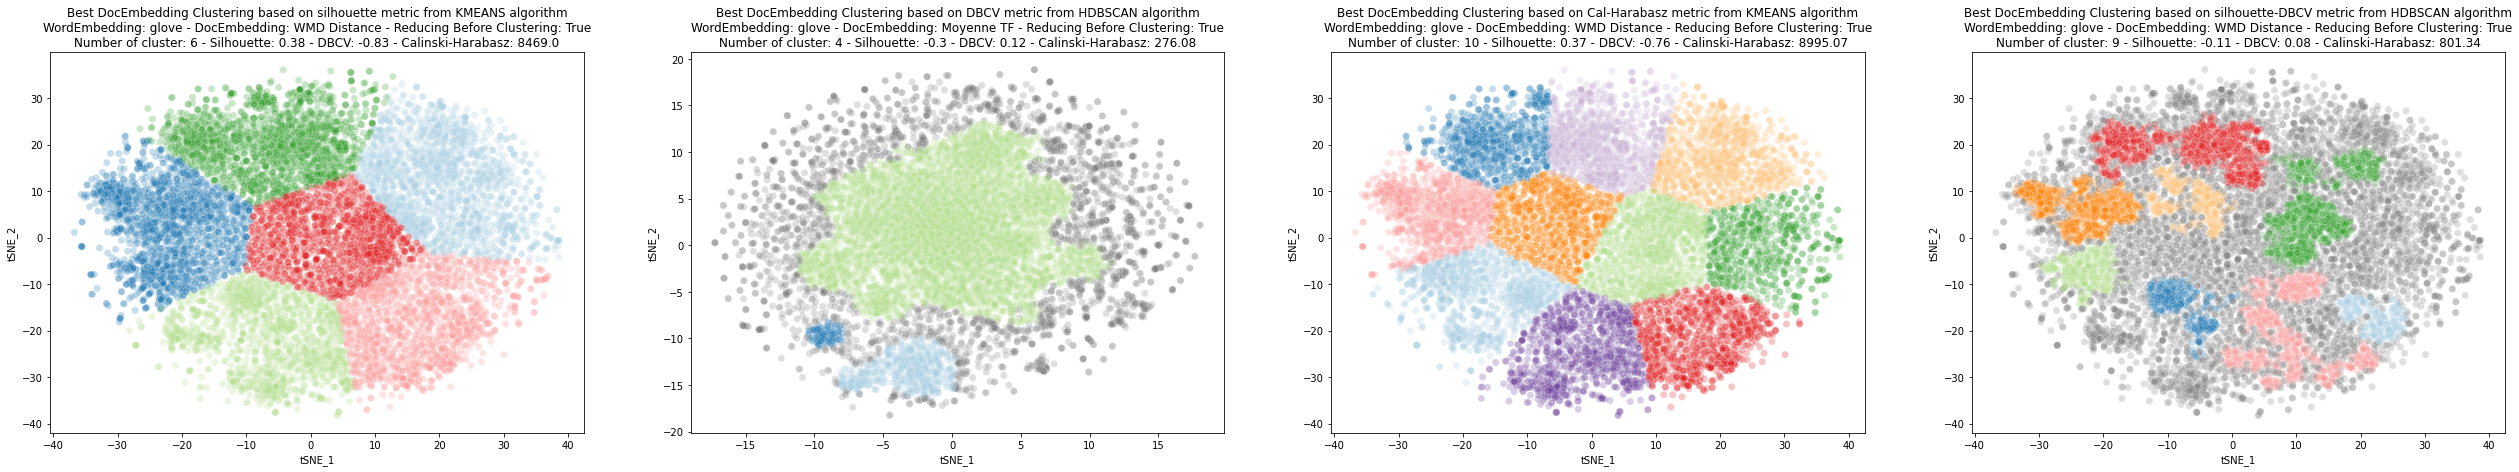

In [38]:
modele = "glove"
print("############################################################################################################################")
print(f"                                                  {modele.upper()}                                                                         ")
print("############################################################################################################################")
dict_label["ReductionFirst"][modele] = {}
dict_label["ReductionAfter"][modele] = {}
for type_reduction in ["ReductionAfter","ReductionFirst"]:
    all_metric = ["silhouette","DBCV", "Cal-Harabasz","silhouette-DBCV"]

    plt.figure(figsize = (44,7))
    for i in range(len(all_metric)):
        dict_label[type_reduction][modele][all_metric[i]] = {}
        #Silhouette
        if type_reduction == "ReductionAfter":
            Labels, Tsne, Colors, Title = plot_best(df_clustering_before,dict_embedding,clustering_metric=all_metric[i],modele=modele)
        else:
            Labels, Tsne, Colors, Title = plot_best(df_clustering_after,dict_embedding,clustering_metric=all_metric[i],modele=modele)
        
        filename = f"{modele}_{type_reduction.lower()}_{all_metric[i]}.csv"
        dict_label[type_reduction][modele][all_metric[i]]["labels"] = Labels
        dict_label[type_reduction][modele][all_metric[i]]["datafilename"] = filename
        pd.DataFrame(Tsne).to_csv(f"data/tuning/clustering/bestmodel/{filename}",sep=";",index=False)
        #plot
        sns.scatterplot(Tsne[:,0],Tsne[:,1], s=50, c=Colors, alpha=0.25,ax=plt.subplot(1,len(all_metric),i+1,title=Title,xlabel="tSNE_1",ylabel="tSNE_2"))
    plt.show()

############################################################################################################################
                                                  CBOW                                                                         
############################################################################################################################


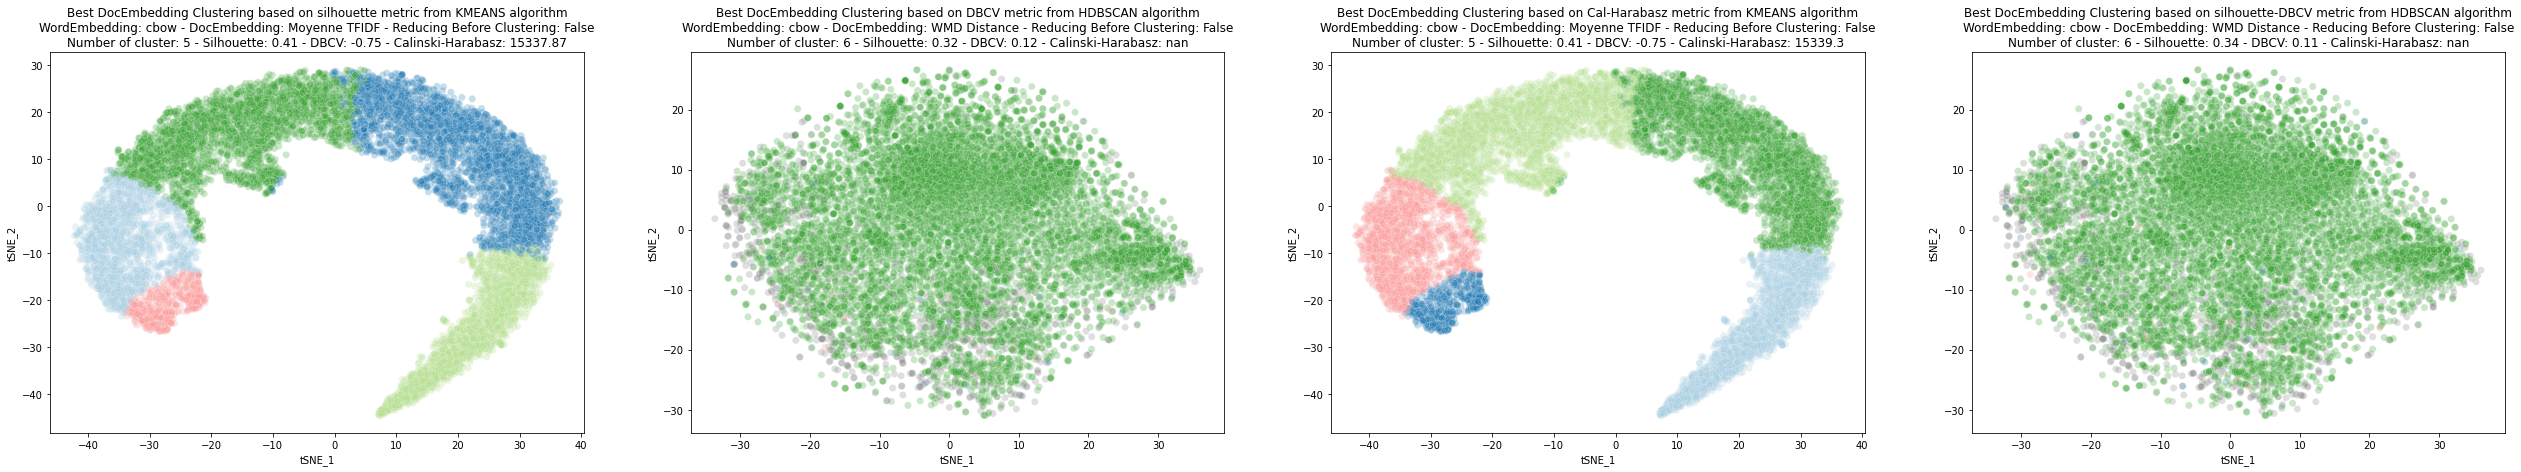

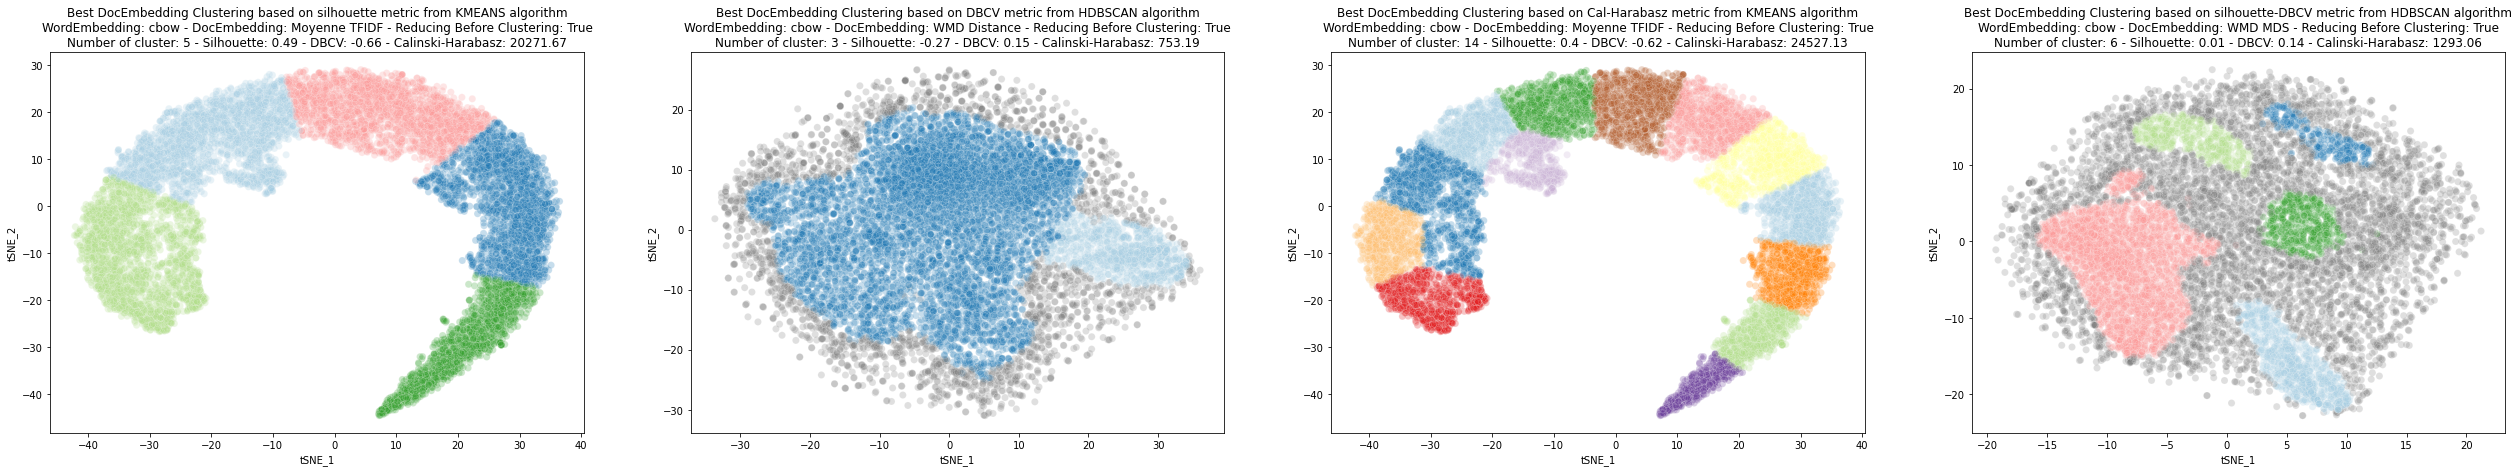

In [37]:
modele = "cbow"
print("############################################################################################################################")
print(f"                                                  {modele.upper()}                                                                         ")
print("############################################################################################################################")
dict_label["ReductionFirst"][modele] = {}
dict_label["ReductionAfter"][modele] = {}
for type_reduction in ["ReductionAfter","ReductionFirst"]:
    all_metric = ["silhouette","DBCV", "Cal-Harabasz","silhouette-DBCV"]

    plt.figure(figsize = (44,7))
    for i in range(len(all_metric)):
        dict_label[type_reduction][modele][all_metric[i]] = {}
        #Silhouette
        if type_reduction == "ReductionAfter":
            Labels, Tsne, Colors, Title = plot_best(df_clustering_before,dict_embedding,clustering_metric=all_metric[i],modele=modele)
        else:
            Labels, Tsne, Colors, Title = plot_best(df_clustering_after,dict_embedding,clustering_metric=all_metric[i],modele=modele)
        
        filename = f"{modele}_{type_reduction.lower()}_{all_metric[i]}.csv"
        dict_label[type_reduction][modele][all_metric[i]]["labels"] = Labels
        dict_label[type_reduction][modele][all_metric[i]]["datafilename"] = filename
        pd.DataFrame(Tsne).to_csv(f"data/tuning/clustering/bestmodel/{filename}",sep=";",index=False)
        #plot
        sns.scatterplot(Tsne[:,0],Tsne[:,1], s=50, c=Colors, alpha=0.25,ax=plt.subplot(1,len(all_metric),i+1,title=Title,xlabel="tSNE_1",ylabel="tSNE_2"))
    plt.show()

In [33]:
with open("data/tuning/clustering/best_labels.json", encoding = "utf8") as f:
    dict_label2 = json.load(f)

In [42]:
import copy
dict_label_copy = copy.deepcopy(dict_label)
for key1 in dict_label_copy.keys():
    for key2 in dict_label_copy[key1].keys():
        for key3 in dict_label_copy[key1][key2].keys():
            dict_label_copy[key1][key2][key3]["labels"] = list(dict_label_copy[key1][key2][key3]["labels"])
            # print(list(dict_label_copy[key1][key2][key3]["labels"]))

In [30]:
def convert(o):
    if isinstance(o, np.generic): return o.item()  
    raise TypeError
saveLabel=True
if saveLabel:
    with open("data/tuning/clustering/best_labels.json", "w") as output_file:
        json.dump(dict_label_copy,output_file,default=convert)